In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

plt.style.use("seaborn-v0_8-darkgrid")


In [20]:
# Download last 60 days of 5-min BTC-USD data
df = yf.download("BTC-USD", period="60d", interval="5m")
df = df[['Close']].dropna()
df.head()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16228\936829700.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("BTC-USD", period="60d", interval="5m")
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,BTC-USD
Datetime,
2025-06-17 00:00:00+00:00,106731.289062
2025-06-17 00:05:00+00:00,106315.039062
2025-06-17 00:10:00+00:00,106247.679688
2025-06-17 00:15:00+00:00,106578.015625
2025-06-17 00:20:00+00:00,106773.937500


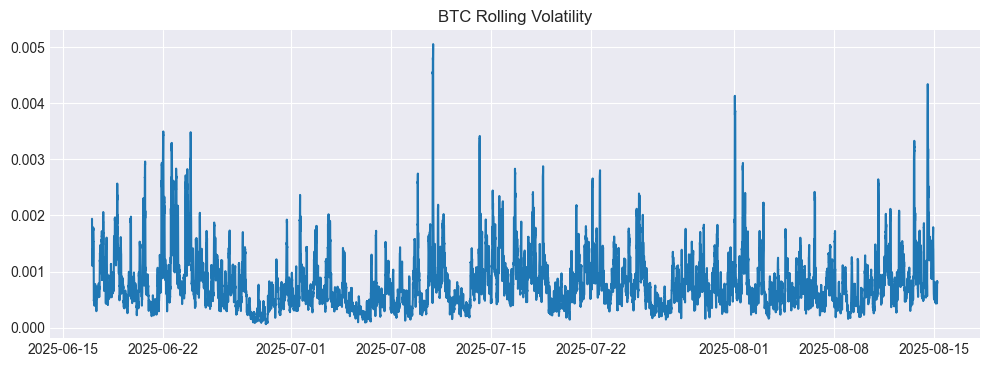

In [21]:
# Calculate rolling volatility (std dev of returns)
df['Returns'] = df['Close'].pct_change()
df['Volatility'] = df['Returns'].rolling(window=12).std()  # ~1 hour window
df = df.dropna()

plt.figure(figsize=(12,4))
plt.plot(df['Volatility'])
plt.title("BTC Rolling Volatility")
plt.show()


In [22]:
scaler = MinMaxScaler()
scaled_vol = scaler.fit_transform(df[['Volatility']])

X, y = [], []
lookback = 24  # 2 hours of history

for i in range(lookback, len(scaled_vol)):
    X.append(scaled_vol[i-lookback:i, 0])
    y.append(scaled_vol[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # LSTM expects 3D

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train.shape, X_test.shape



((13617, 24, 1), (3405, 24, 1))

In [24]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32)


Epoch 1/5
426/426 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - loss: 0.2858 - val_loss: 0.0035
Epoch 2/5
426/426 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0695 - val_loss: 0.0155
Epoch 3/5
426/426 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0121 - val_loss: 0.0028
Epoch 4/5
426/426 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0046 - val_loss: 7.4099e-04
Epoch 5/5
426/426 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0031 - val_loss: 0.0015


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


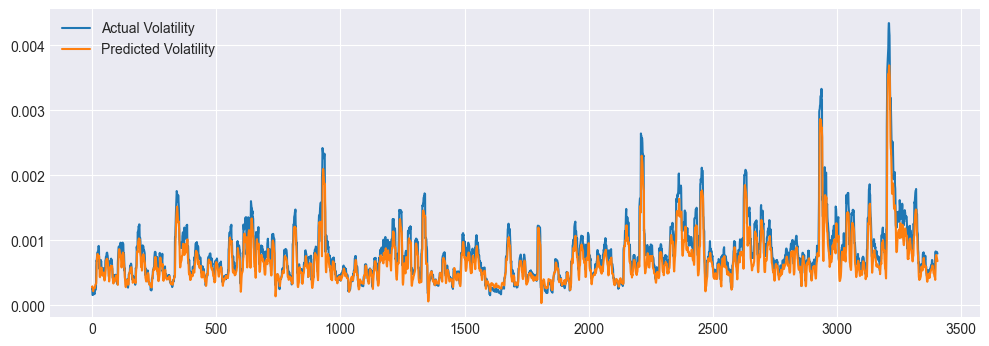

In [25]:
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1, 1))
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12,4))
plt.plot(actual, label="Actual Volatility")
plt.plot(preds, label="Predicted Volatility")
plt.legend()
plt.show()


In [27]:
# Save metrics and prediction plot to the repo
import os, json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("artifacts", exist_ok=True)

rmse = float(np.sqrt(mean_squared_error(actual, preds)))
mae  = float(mean_absolute_error(actual, preds))
r2   = float(r2_score(actual, preds))

with open("artifacts/metrics.json", "w") as f:
    json.dump({"rmse": rmse, "mae": mae, "r2": r2}, f, indent=2)

plt.figure(figsize=(12,4))
plt.plot(actual, label="Actual Volatility")
plt.plot(preds,  label="Predicted Volatility")
plt.legend()
plt.title("LSTM Volatility: Actual vs Predicted")
plt.tight_layout()
plt.savefig("artifacts/volatility_predictions.png", dpi=150)
plt.close()

print("Saved:")
print("- artifacts/metrics.json")
print("- artifacts/volatility_predictions.png")


Saved:
- artifacts/metrics.json
- artifacts/volatility_predictions.png
